In [1]:
# Импорт библиотек
import os
import time
import ASW
import GTU
import KU_TU
import mat_properties as prop
import numpy as n
import pandas as pd
import SP
from scipy.optimize import root

# таблица номинального режима
gas_streams0 = pd.read_excel("streams0.xlsx", sheet_name="gas", index_col=0)
water_streams0 = pd.read_excel("streams0.xlsx", sheet_name="water", index_col=0)
GTU_ISO = pd.read_excel("input.xlsx", sheet_name="ISO", index_col=0)
GTU_input = pd.read_excel("input.xlsx", sheet_name="GTU_input", index_col=0)
# рабочая таблица (=номинал в 1 итерации)
gas_streams = pd.read_excel("streams.xlsx", sheet_name="gas", index_col=0)
water_streams = pd.read_excel("streams.xlsx", sheet_name="water", index_col=0)
# рабочая таблица показателей блоков
heaters = pd.read_excel("blocks.xlsx", sheet_name="heaters", index_col=0)
electric = pd.read_excel("blocks.xlsx", sheet_name="electric", index_col=0)

# Состав газов в номинале
gasmix = "Nitrogen*Oxygen*CO2*Water*Argon"
# Считывание рефпропа
RP = prop.init_REFPROP(r"C:\Program Files (x86)\REFPROP")
fractiongas0 = (
    gas_streams0.at["GTU-PEVD", "N2"],
    gas_streams0.at["GTU-PEVD", "O2"],
    gas_streams0.at["GTU-PEVD", "CO2"],
    gas_streams0.at["GTU-PEVD", "H2O"],
    gas_streams0.at["GTU-PEVD", "Ar"],
)

gas0 = prop.Materials_prop(
    gasmix,
    fractiongas0,
    prop.REFPROP_h_s,
    prop.REFPROP_p_t,
    prop.REFPROP_p_h,
    prop.REFPROP_p_s,
    prop.REFPROP_p_q,
    prop.REFPROP_t_q,
    prop.REFPROP_p_rho,
    prop.REFPROP_s_q,
    RP=RP,
)
water = prop.Materials_prop(
    "water",
    [1.0, 0, 0, 0, 0],
    prop.REFPROP_h_s,
    prop.REFPROP_p_t,
    prop.REFPROP_p_h,
    prop.REFPROP_p_s,
    prop.REFPROP_p_q,
    prop.REFPROP_t_q,
    prop.REFPROP_p_rho,
    prop.REFPROP_s_q,
    RP=RP,
)

# Задание энтальпий газа в номинальном режиме
Temperatures = gas_streams0.loc["GTU-KU":"GPK-out", "T"]
Pressure = gas_streams0.loc["GTU-KU", "P"]
Enthalpies = list(map(lambda x: gas0.p_t(Pressure, x)["h"], Temperatures))
gas_streams0.loc["GTU-KU":"GPK-out", "H"] = Enthalpies

############################################################
# Расчет ГТУ
Gas_turbine = GTU.gtu(GTU_ISO, GTU_input, "GTU-KU")
Gas_turbine_res = Gas_turbine.calc()
electric.at["GTU", "N"] = Gas_turbine_res["N"]
electric.at["GTU", "KPD"] = Gas_turbine_res["eff"]
electric.at["DK", "N"] = Gas_turbine_res["Ndk"]
gas_streams = pd.read_excel("streams.xlsx", sheet_name="gas", index_col=0)
gas_streams.at["GTU-KU", "T"] = Gas_turbine_res["T"]
gas_streams.at["GTU-KU", "G"] = Gas_turbine_res["G"]
gas_streams.at["GTU-KU", "P"] = 0.1
gas_streams.at["GTU-KU", "H"] = gas0.p_t(
    gas_streams.at["GTU-KU", "P"], gas_streams.at["GTU-KU", "T"]
)["h"]
Gas_turbine_composition = pd.read_excel(
    "input.xlsx", sheet_name="Gas_composition0", index_col=0
)

# Параметры газа на выходе в КУ
gas_streams.loc["GTU-PEVD", "T":"P"] = gas_streams.loc["GTU-KU", "T":"P"]
gas_streams.at["GTU-PEVD", "G"] = gas_streams.loc["GTU-KU", "G"]
gas_streams.loc["GTU-PEVD", "N2":"Ar"] = Gas_turbine_composition.loc[
    "Fraction", "N2":"Ar"
]

############################################################
# Теплосеть
gas_streams.loc["AIR", "T":"P"] = [GTU_input.loc["tair", 1], 0.1]
water_streams.loc["AIR", "T":"P"] = [GTU_input.loc["tair", 1], 0.1]
Tnv = gas_streams.at["AIR", "T"]
water_streams.at["SWIN-TURB", "T"] = SP.Tset(Tnv)[1]
water_streams.at["SP2-WOUT", "T"] = SP.Tset(Tnv)[0]

water_streams.at["SWOUT", "T"] = SP.Tset(Tnv)[0]
water_streams.at["SWIN", "T"] = SP.Tset(Tnv)[1]
# print(water_streams)
############################################################

# Состав газов при частичной нагрузке
fractiongas = (
    gas_streams.at["GTU-PEVD", "N2"],
    gas_streams.at["GTU-PEVD", "O2"],
    gas_streams.at["GTU-PEVD", "CO2"],
    gas_streams.at["GTU-PEVD", "H2O"],
    gas_streams.at["GTU-PEVD", "Ar"],
)
gas1 = prop.Materials_prop(
    gasmix,
    fractiongas,
    prop.REFPROP_h_s,
    prop.REFPROP_p_t,
    prop.REFPROP_p_h,
    prop.REFPROP_p_s,
    prop.REFPROP_p_q,
    prop.REFPROP_t_q,
    prop.REFPROP_p_rho,
    prop.REFPROP_s_q,
    RP=RP,
)

# Основные константы
Calcmethod = "hybr"
KPD_PN = 0.8074
KPD_KN = 0.75
KPD_to = 0.99
KPD_SP = 0.99

Calctolerance = 10**-2
Teplo = 1
Maxiterations_KU_TU = 20
Maxiterations_cotel = 4
Maxiterations_turbine = 30
steamVD_fraction_to_turbine=1
steamVD_to_turbine=0
# Class KU+TU
KU_and_TU = KU_TU.ku_tu(
    gas0,
    gas1,
    water,
    gas_streams0,
    gas_streams,
    water_streams0,
    water_streams,
    heaters,
    electric,
    "PEVD-DROSVD",
    "PPND-DROSND",
    "DROSVD-TURBVD",
    "DROSND-TURBND",
    Calcmethod,
    KPD_SP,
    KPD_KN,
    KPD_to,
    KPD_PN,    
    steamVD_fraction_to_turbine,
    steamVD_to_turbine,
)


ASW = ASW.Accum(water,water_streams,heaters,
                 stream12 = "ASW-WOUT",
                 stream11 = "SP2-ASW",
                 stream_obratnoi_setevoi_vody = "SWIN-TURB",
                 stream_pryamoi_setevoi_vody = "SP2-WOUT",
                 T_nar_vozd = -23)

ASW.set_construct(Diametr=2,
                   kolichestvo = 4,
                   Visota = 2,
                   lambda_min_vata = 0.045,
                   delta_min_vata = 0.01)


start_time = time.time()

vremya = 4
ASW.zaryadka(vremya)
ASW.jdat(12)
# # При расчете только на зарядке убрать слэш

# G_ASW_zarydka = ASW.zaryadka(vremya)['G']
# water_streams.at["SWIN-TURB", "G"] = water_streams.at["SWIN", "G"] + G_ASW_zarydka
# water_streams.at["SP2-WOUT", "G"] = water_streams.at["SWIN", "G"] + G_ASW_zarydka
G_ASW_razryadka = ASW.razryadka(vremya)['G']
water_streams.at["SWIN-TURB", "G"] = water_streams.at["SWIN", "G"] - G_ASW_razryadka
water_streams.at["SP2-WOUT", "G"] = water_streams.at["SWIN", "G"] - G_ASW_razryadka
water_streams.at["SWOUT", "H"] = water.p_t(water_streams.at["SWOUT","P"],water_streams.at["SWOUT", "T"])['h']
water_streams.at["SP2-WOUT", "H"] = (water_streams.at["SWOUT", "H"]*water_streams.at["SWOUT", "G"] -
                                    water_streams.at["ASW-WOUT", "H"]*G_ASW_razryadka)/(water_streams.at["SWOUT", "G"]-G_ASW_razryadka)
water_streams.at["SP2-WOUT", "T"] = water.p_h(water_streams.at["SP2-WOUT", "P"],water_streams.at["SP2-WOUT", "H"])['T']

print(G_ASW_razryadka)
print(water_streams.at["SWOUT", "H"])
print(water_streams.at["SP2-WOUT", "T"])
print(water_streams.at["SP2-WOUT", "G"])
print(water_streams.at["SWOUT", "T"])
print(water_streams.at["SWIN", "T"])

KU_and_TU.calculate(
    Teplo,
    Calctolerance,
    Maxiterations_KU_TU,
    Maxiterations_cotel,
    Maxiterations_turbine,
)

print(
    "Степень сухости пара в ЭВД: ",
    water.p_h(water_streams.at["EVD-IVD", "P"], water_streams.at["EVD-IVD", "H"])["Q"],
)
print(
    "Степень сухости пара в ГПК: ",
    water.p_h(water_streams.at["GPK-IND", "P"], water_streams.at["GPK-IND", "H"])["Q"],
)

print(f"fin КУ и ТУ:--- {round((time.time() - start_time), 1)} сек. ---")

1.6855003821129124
377.75901533255535
90.03656847575519
748.3144996178871
90.0
36.79643217
Достигнуто максимальное количество итераций контура высокого давления
Fin котел-утилизатора:--- 4.22 сек. ---
dQ/Qsumm 0.07551579571003175
Fin турбоустановка:--- 0.05 сек. ---
Достигнуто максимальное количество итераций контура низкого давления
Достигнуто максимальное количество итераций контура низкого давления
Достигнуто максимальное количество итераций контура низкого давления
Повышена точность расчета котла для увеличения сходимости
dQ/Q ПЕВД+ИВД+ЭВД 2.5605848670382727
dQ/Q ПЕВД+ИВД+ЭВД -1.4729720859768056
dQ/Q ПЕВД+ИВД+ЭВД 0.7166022004702418
dQ/Q ПЕВД+ИВД+ЭВД -0.35390927798321775
Достигнуто максимальное количество итераций контура высокого давления
dQ/Q ППНД+ИНД+ГПК 0.4755715270600454
dQ/Q ППНД+ИНД+ГПК -0.08264631129767279
Достигнуто максимальное количество итераций котла-утилизатора
Fin турбоустановка:--- 0.04 сек. ---
Достигнуто максимальное количество итераций контура высокого давления
До

In [2]:
# Вывод газовых потоков
gas_streams

,T,P,H,G,N2,O2,CO2,H2O,Ar
AIR,7.000000,0.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GTU-KU,538.050799,0.1,953.973857,516.972994,0.7803,0.1237,0.0301,0.0594,0.0065
REF-SMESH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GTU-PEVD,538.050799,0.1,953.973857,516.972994,0.7803,0.1237,0.0301,0.0594,0.0065
PEVD-IVD,465.753685,0.1,871.431194,516.972994,0.7803,0.1237,0.0301,0.0594,0.0065
IVD-EVD,309.011630,0.1,697.211778,516.972994,0.7803,0.1237,0.0301,0.0594,0.0065
EVD-PPND,235.441853,0.1,617.586826,516.972994,0.7803,0.1237,0.0301,0.0594,0.0065
PPND-IND,232.570804,0.1,614.504761,516.972994,0.7803,0.1237,0.0301,0.0594,0.0065
IND-GPK,173.320434,0.1,551.280955,516.972994,0.7803,0.1237,0.0301,0.0594,0.0065
GPK-out,101.446773,0.1,475.427082,516.972994,0.7803,0.1237,0.0301,0.0594,0.0065


In [3]:
# Вывод водяных потоков
water_streams

,T,P,H,G,S,X
AIR,7.0,0.1,NaN,NaN,NaN,NaN
PEVD-DROSVD,508.077199,8.368959,3415.161617,63.295824,NaN,NaN
IVD-PEVD,300.988842,8.708185,2747.714223,63.295824,NaN,NaN
EVD-IVD,298.98032,8.708185,1339.021114,63.295824,NaN,NaN
PEN-EVD,163.464414,8.708185,695.178921,63.295824,NaN,NaN
BND-PEN,162.002703,0.650371,684.180635,63.295824,NaN,NaN
PPND-DROSND,207.616373,0.644434,2865.023717,14.965397,NaN,NaN
IND-PPND,162.002703,0.650371,2759.623673,14.965397,NaN,NaN
GPK-IND,158.175899,0.650371,667.589372,78.261221,NaN,NaN
GPK-REC,158.175899,0.650371,667.589372,93.349754,NaN,NaN


In [4]:
Errors_water = abs(water_streams - water_streams0) / water_streams0 * 100
Errors_gas = abs(gas_streams - gas_streams0) / gas_streams0 * 100
Errors_gas
Errors_water

,G,H,P,S,T,X
AIR,NaN,NaN,NaN,NaN,53.333333,NaN
ASW-OD,NaN,NaN,NaN,NaN,NaN,NaN
ASW-WOUT,NaN,NaN,NaN,NaN,NaN,NaN
BND-PEN,0.164316,1.711681,6.609632,NaN,1.660608,NaN
DOOTB1,49.647458,5.297345,82.713878,5.411068,NaN,NaN
DOOTB2,0.129505,3.102452,60.012348,2.729750,23.848054,NaN
DROSND-TURBND,1.391579,0.222998,8.862763,0.403449,1.996239,NaN
DROSVD-ST,NaN,NaN,NaN,NaN,NaN,NaN
DROSVD-TURBVD,0.164316,0.215159,0.451262,NaN,0.621938,NaN
ENDOFVD,0.164316,0.702977,10.180154,NaN,5.428661,NaN


In [5]:
gas_streams0

,T,P,H,G,N2,O2,CO2,H2O,Ar
AIR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GTU-KU,542.10,0.1,958.637030,503.8,0.7803,0.1237,0.0301,0.0594,0.0065
REF-SMESH,NaN,NaN,-9999.990000,NaN,NaN,NaN,NaN,NaN,NaN
GTU-PEVD,542.10,0.1,958.637030,503.8,0.7803,0.1237,0.0301,0.0594,0.0065
PEVD-IVD,468.05,0.1,874.031830,503.8,0.7803,0.1237,0.0301,0.0594,0.0065
IVD-EVD,309.20,0.1,697.417326,503.8,0.7803,0.1237,0.0301,0.0594,0.0065
EVD-PPND,235.90,0.1,618.078812,503.8,0.7803,0.1237,0.0301,0.0594,0.0065
PPND-IND,233.00,0.1,614.965387,503.8,0.7803,0.1237,0.0301,0.0594,0.0065
IND-GPK,175.50,0.1,553.594555,503.8,0.7803,0.1237,0.0301,0.0594,0.0065
GPK-out,106.90,0.1,481.155410,503.8,0.7803,0.1237,0.0301,0.0594,0.0065


In [6]:
electric

,Ni,N,KPDm,KPD
PEN,0.696146,0.713226,0.976053,0.807400
CVD,NaN,NaN,NaN,NaN
CND,NaN,NaN,NaN,NaN
GTU,NaN,157.979400,NaN,33.745787
DK,NaN,6.285084,NaN,NaN
Turbine,57.788625,NaN,NaN,NaN
Tots1,37.399677,NaN,NaN,0.848244
Tots2,15.007028,NaN,NaN,0.679608
Tots3,0.312548,NaN,NaN,0.617632
Tots4,5.069372,NaN,NaN,0.192784


In [7]:
heaters

,Qw,Qg,KPD
PEVD,42245.604463,42672.327741,0.99
IVD,89166.065626,90066.732956,0.99
EVD,40752.310780,41163.950283,0.99
PPND,1577.410881,1593.344324,0.99
IND,32358.150197,32685.000199,0.99
GPK,38822.259584,39214.403620,0.99
SP2,85.765097,NaN,0.99
SP1,74.490764,NaN,0.99
OD,6.555751,NaN,0.99
ASW,0.000000,NaN,NaN


In [8]:
GTU_input

,1,2,3,4,5,6
tair,7,NaN,NaN,NaN,NaN,NaN
n,1,NaN,NaN,NaN,NaN,NaN
Pin,0,NaN,NaN,NaN,NaN,NaN
Pout,0,NaN,NaN,NaN,NaN,NaN


,T,P,H,G,S,X
AIR,7.0,0.1,NaN,NaN,NaN,NaN
PEVD-DROSVD,508.077199,8.368959,3415.161617,63.295824,6.727265,NaN
IVD-PEVD,300.988842,8.708185,2747.714223,63.295824,NaN,NaN
EVD-IVD,298.98032,8.708185,1339.021114,63.295824,NaN,NaN
PEN-EVD,163.464414,8.708185,695.178921,63.295824,NaN,NaN
BND-PEN,162.002703,0.650371,684.180635,63.295824,NaN,NaN
PPND-DROSND,207.616373,0.644434,2865.023717,14.965397,6.966635,NaN
IND-PPND,162.002703,0.650371,2759.623673,14.965397,NaN,NaN
GPK-IND,158.175899,0.650371,667.589372,78.261221,NaN,NaN
GPK-REC,158.175899,0.650371,667.589372,93.349754,NaN,NaN


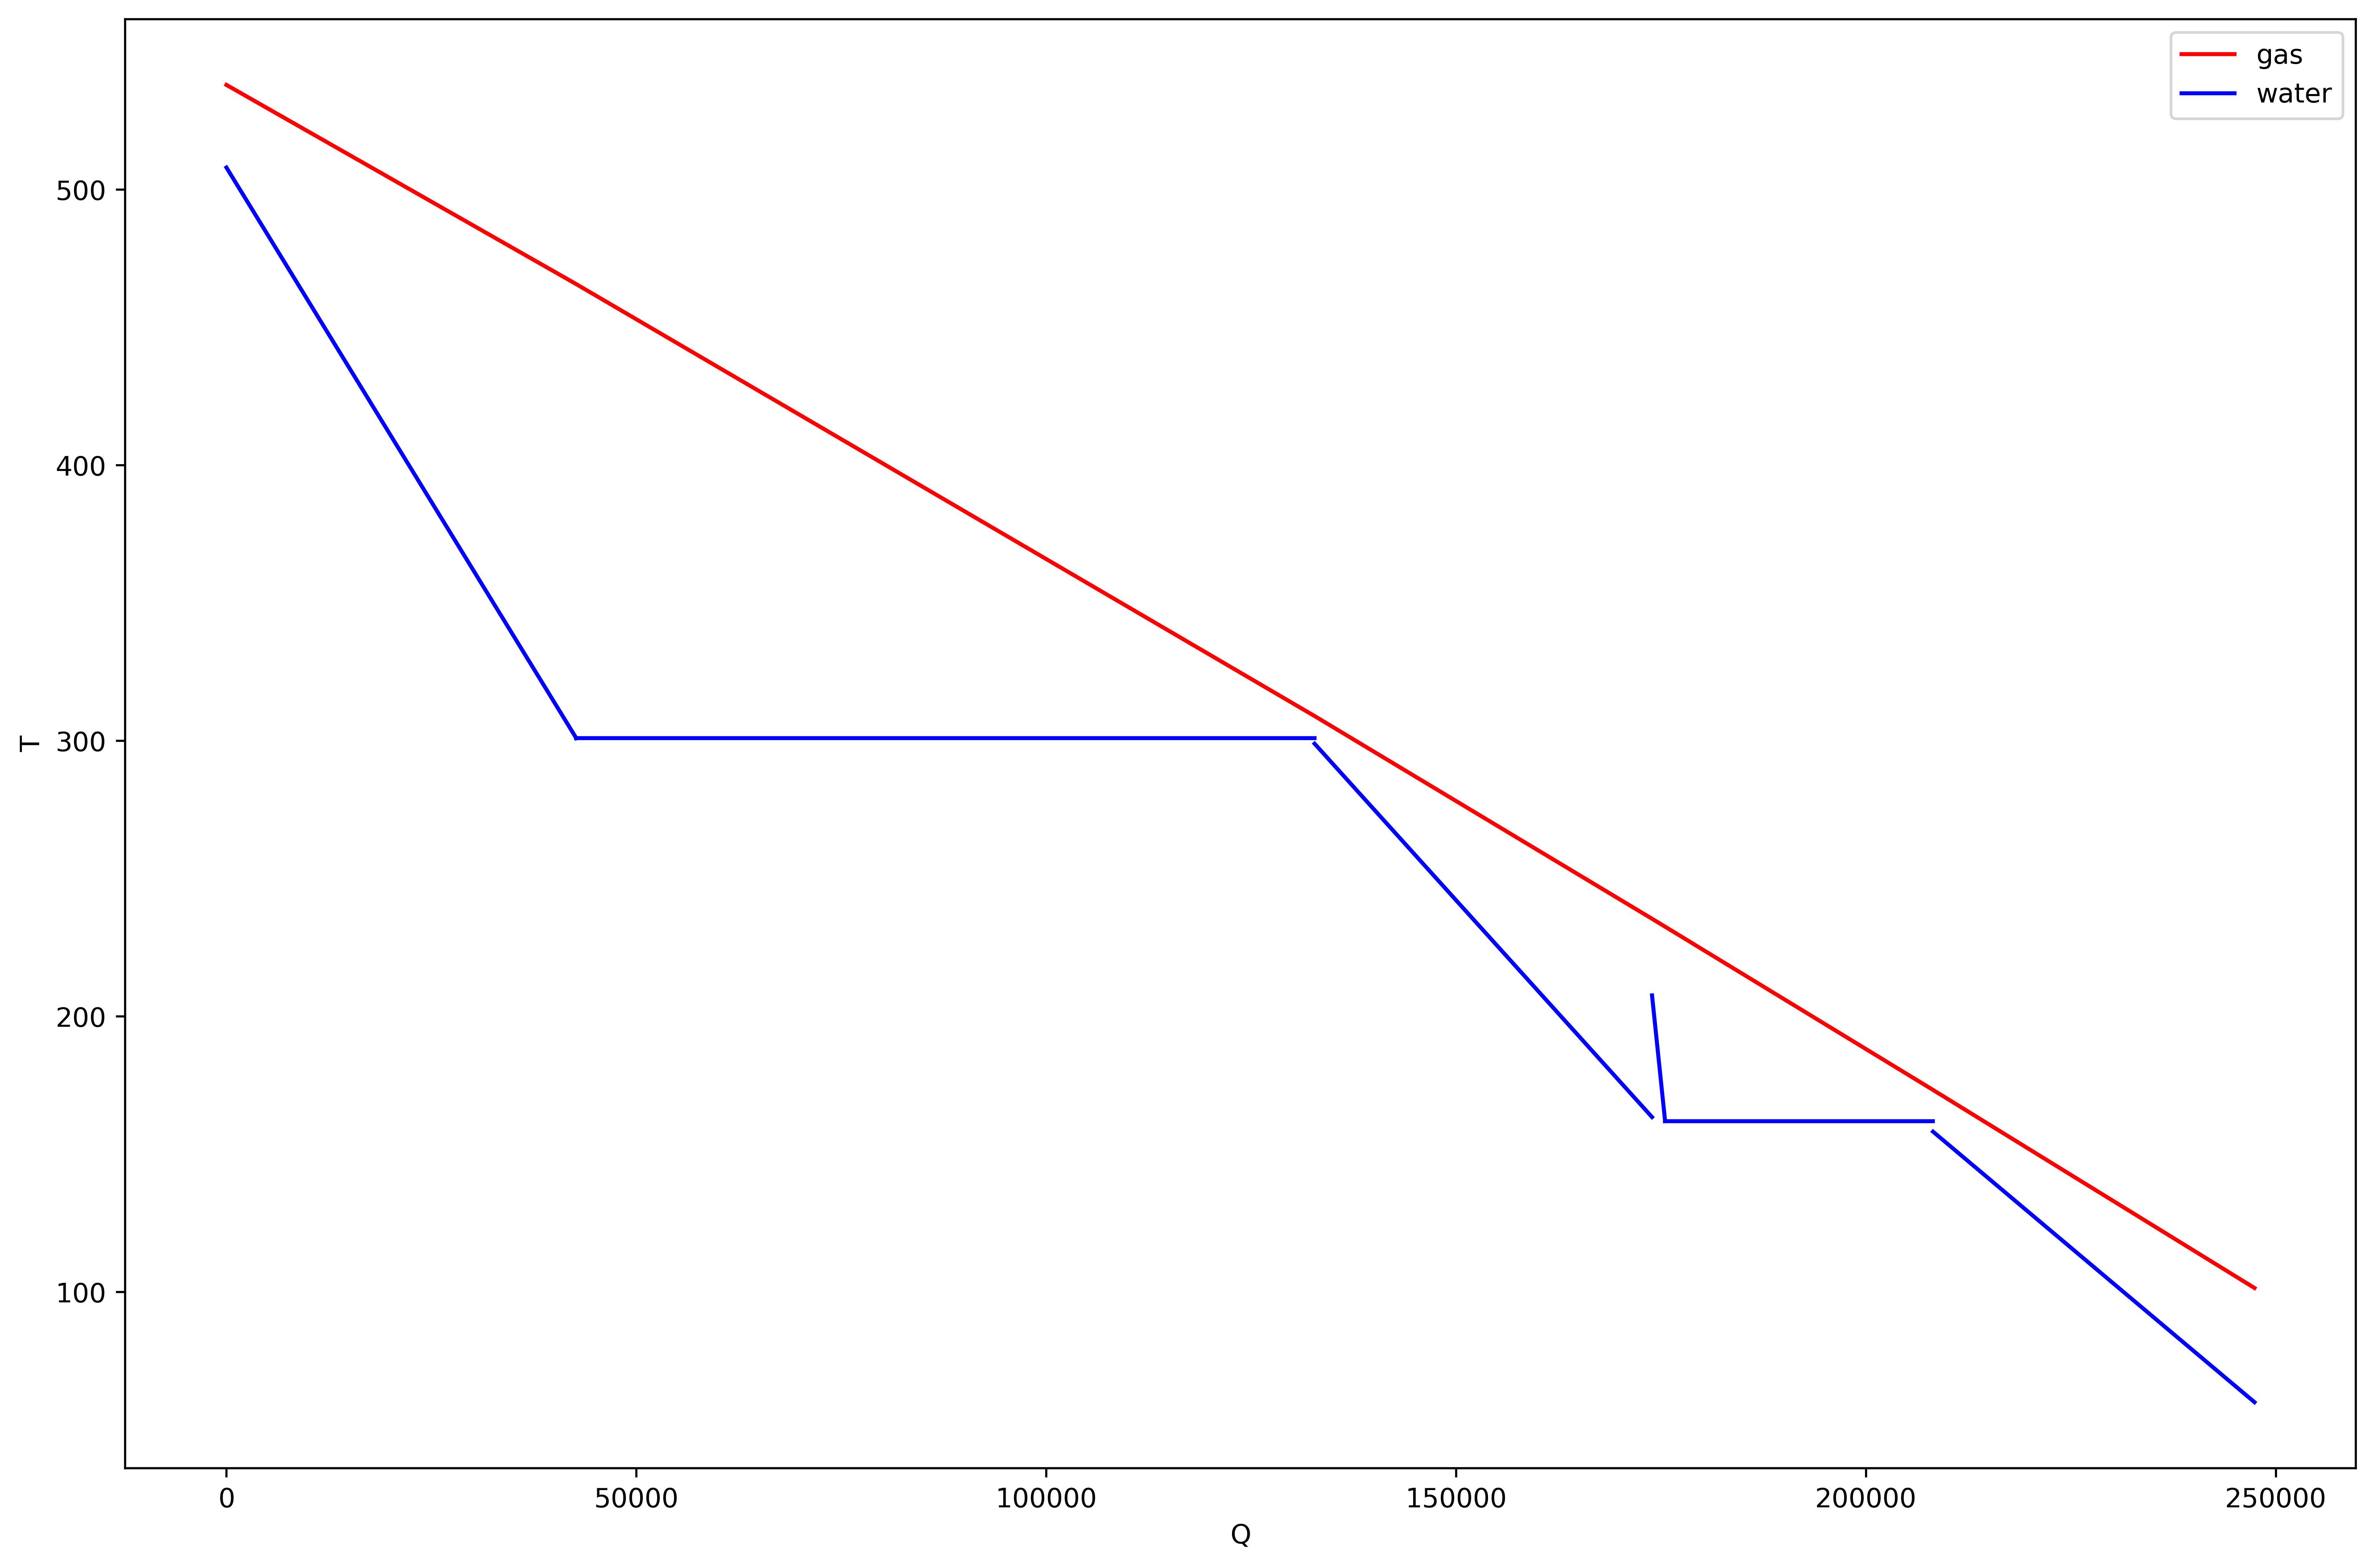

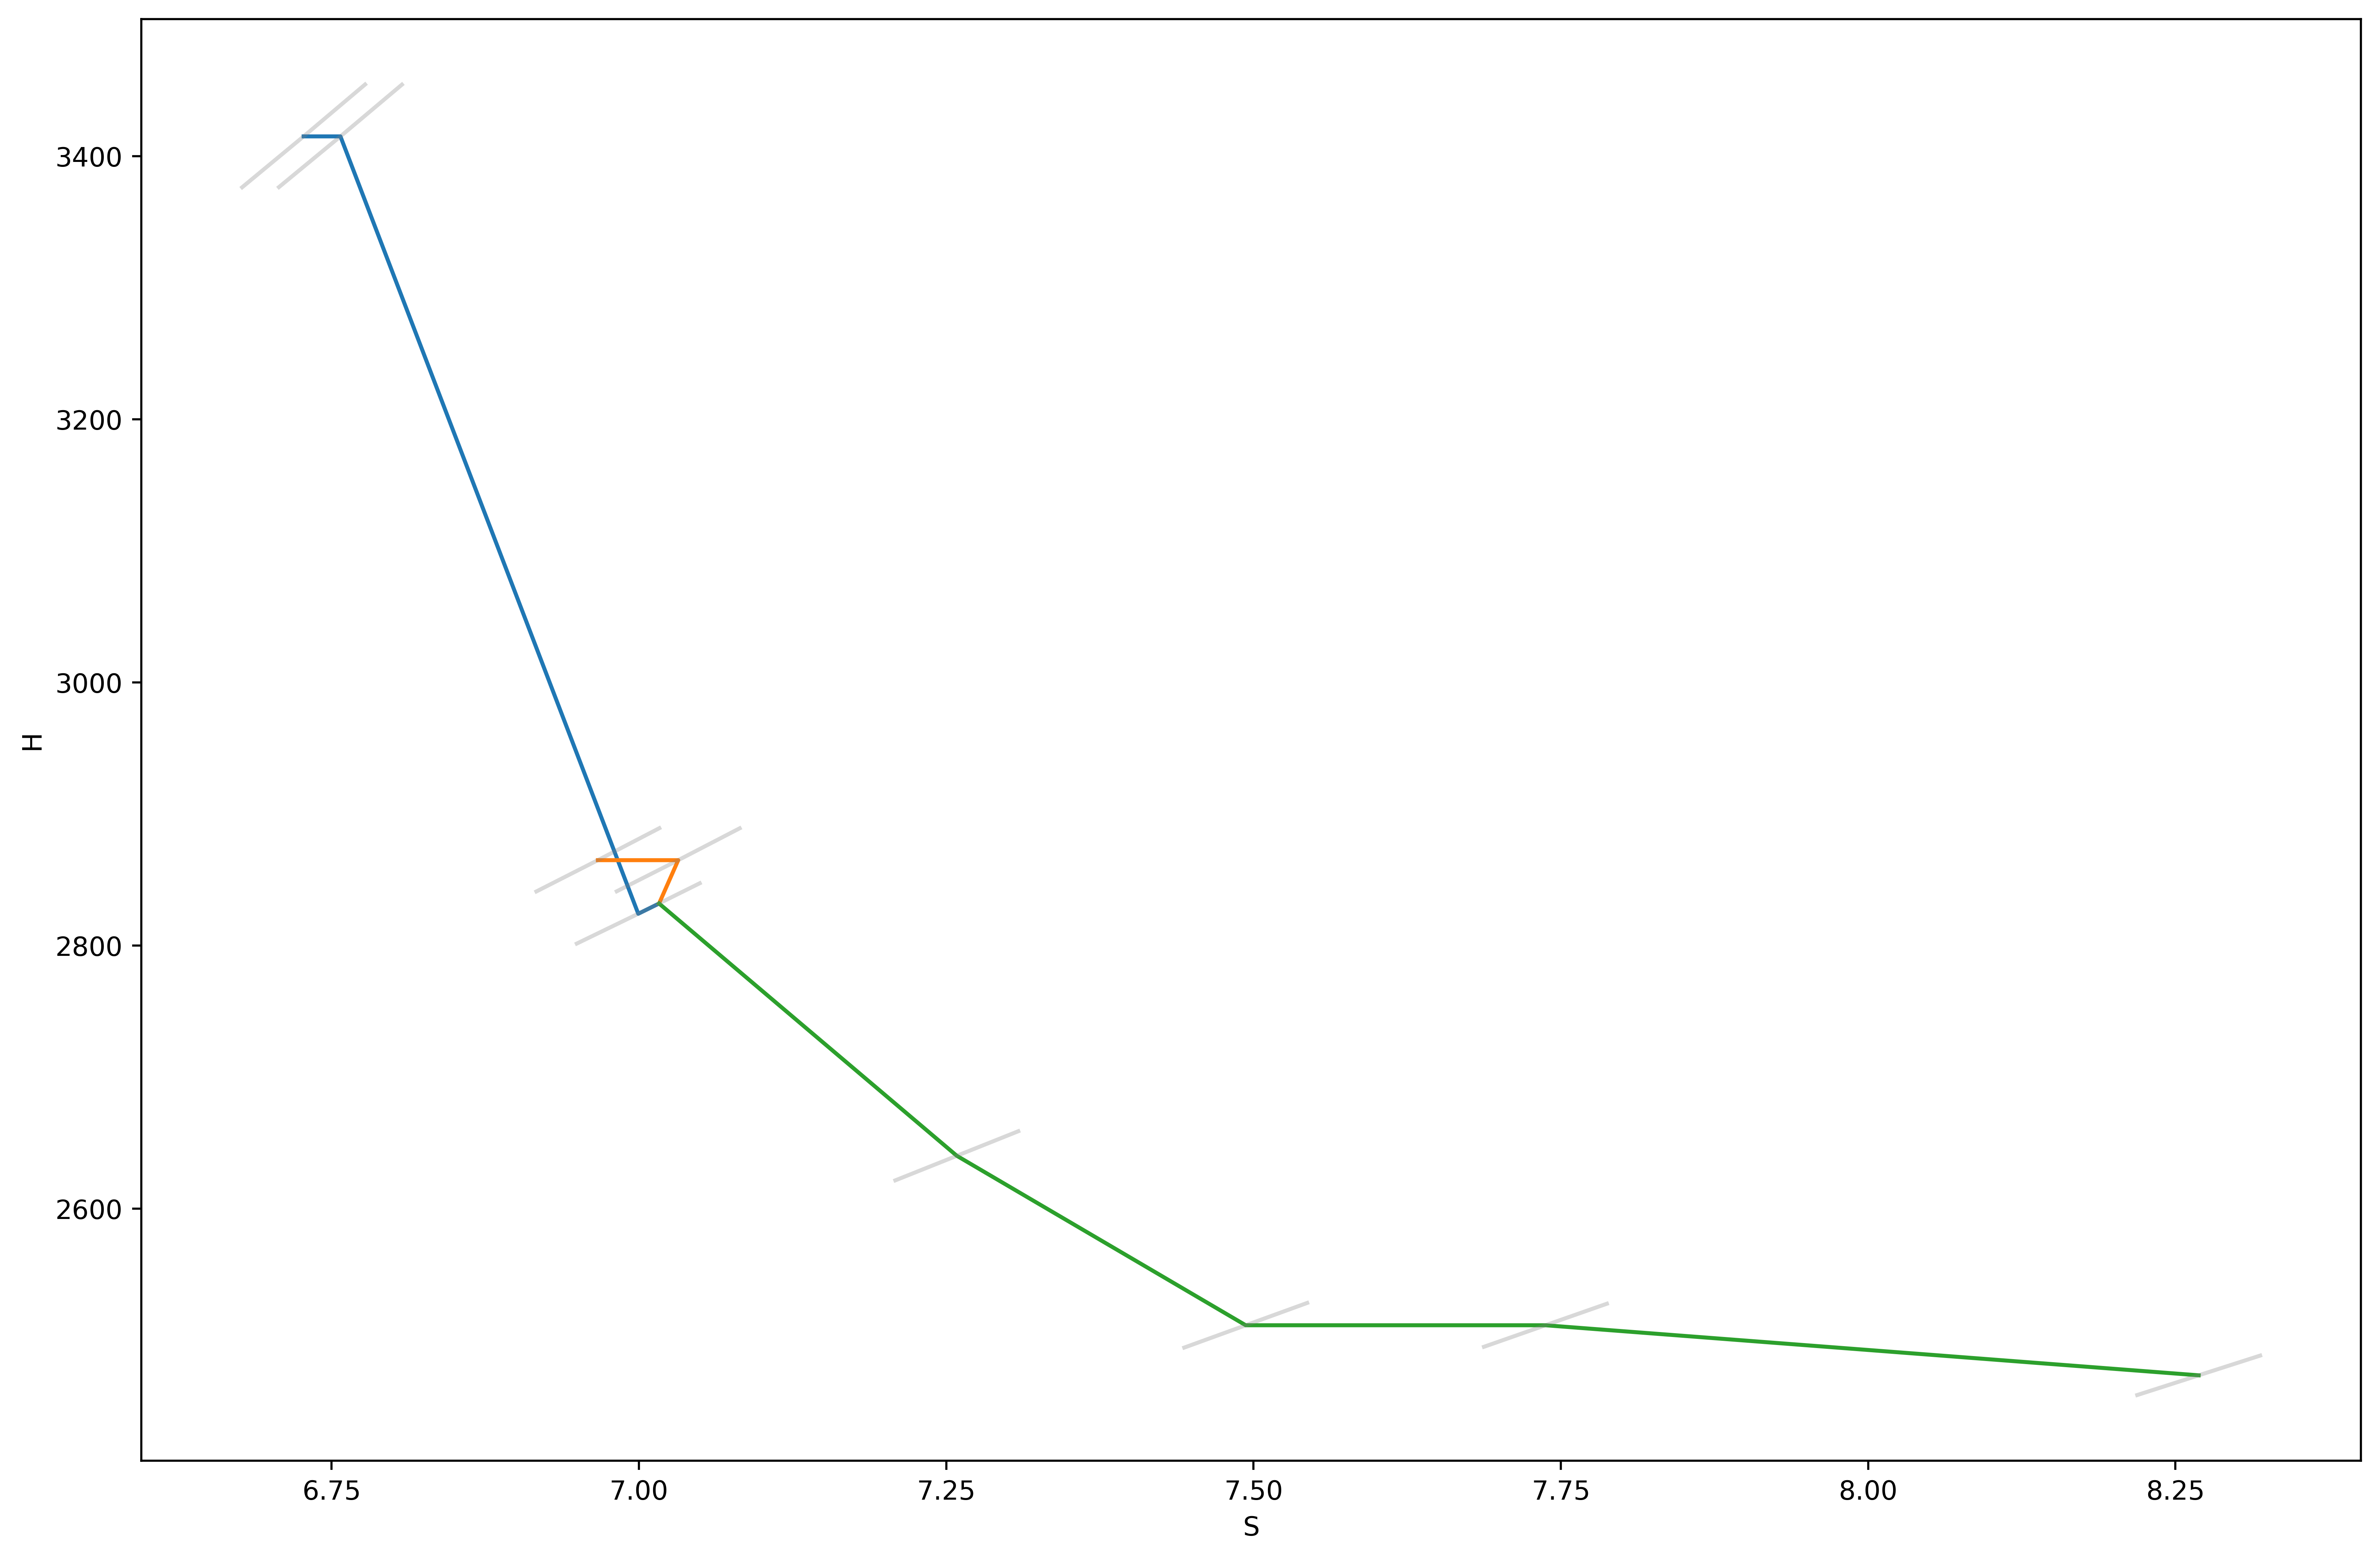

In [9]:
import Grafiki

Grafiki.Q_t_diagram(gas_streams, water_streams, heaters, 15, 10)
Grafiki.H_S_diagram(water, water_streams, 15, 10)
water_streams

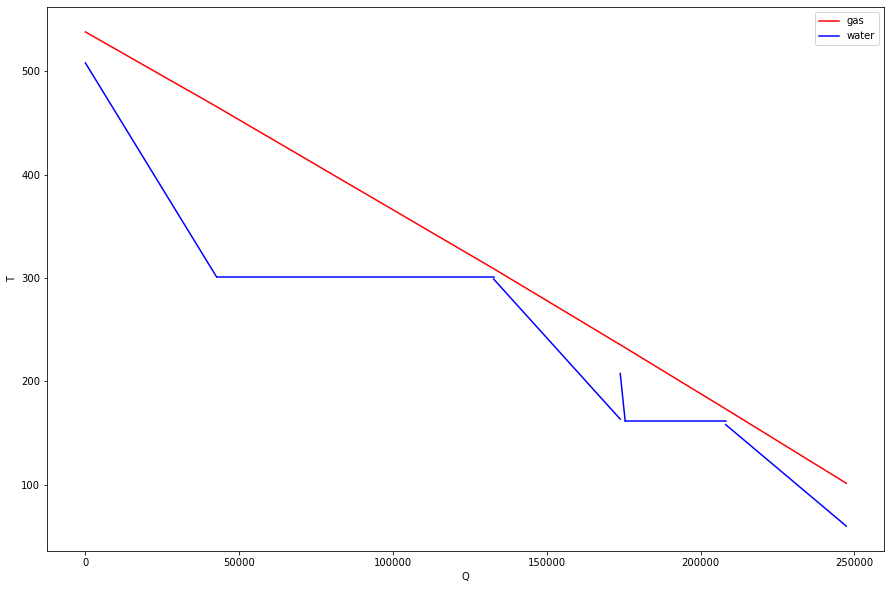

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
Qg = [
    0,
    heaters.loc["PEVD", "Qg"],
    heaters.loc["PEVD", "Qg"] + heaters.loc["IVD", "Qg"],
    heaters.loc["PEVD", "Qg"] + heaters.loc["IVD", "Qg"] + heaters.loc["EVD", "Qg"],
    heaters.loc["PEVD", "Qg"]
    + heaters.loc["IVD", "Qg"]
    + heaters.loc["EVD", "Qg"]
    + heaters.loc["PPND", "Qg"],
    heaters.loc["PEVD", "Qg"]
    + heaters.loc["IVD", "Qg"]
    + heaters.loc["EVD", "Qg"]
    + heaters.loc["PPND", "Qg"]
    + heaters.loc["IND", "Qg"],
    heaters.loc["PEVD", "Qg"]
    + heaters.loc["IVD", "Qg"]
    + heaters.loc["EVD", "Qg"]
    + heaters.loc["PPND", "Qg"]
    + heaters.loc["IND", "Qg"]
    + heaters.loc["GPK", "Qg"],
]
Qw = [
    0,
    heaters.loc["PEVD", "Qg"],
    heaters.loc["PEVD", "Qg"] + heaters.loc["IVD", "Qg"],
    heaters.loc["PEVD", "Qg"] + heaters.loc["IVD", "Qg"],
    heaters.loc["PEVD", "Qg"] + heaters.loc["IVD", "Qg"] + heaters.loc["EVD", "Qg"],
    heaters.loc["PEVD", "Qg"] + heaters.loc["IVD", "Qg"] + heaters.loc["EVD", "Qg"],
    heaters.loc["PEVD", "Qg"]
    + heaters.loc["IVD", "Qg"]
    + heaters.loc["EVD", "Qg"]
    + heaters.loc["PPND", "Qg"],
    heaters.loc["PEVD", "Qg"]
    + heaters.loc["IVD", "Qg"]
    + heaters.loc["EVD", "Qg"]
    + heaters.loc["PPND", "Qg"]
    + heaters.loc["IND", "Qg"],
    heaters.loc["PEVD", "Qg"]
    + heaters.loc["IVD", "Qg"]
    + heaters.loc["EVD", "Qg"]
    + heaters.loc["PPND", "Qg"]
    + heaters.loc["IND", "Qg"],
    heaters.loc["PEVD", "Qg"]
    + heaters.loc["IVD", "Qg"]
    + heaters.loc["EVD", "Qg"]
    + heaters.loc["PPND", "Qg"]
    + heaters.loc["IND", "Qg"]
    + heaters.loc["GPK", "Qg"],
]
Tg = gas_streams.loc["GTU-PEVD":"GPK-out", "T"]
Tw = [
    water_streams.loc["PEVD-DROSVD", "T"],
    water_streams.loc["IVD-PEVD", "T"],
    water_streams.loc["IVD-PEVD", "T"],
    water_streams.loc["EVD-IVD", "T"],
    water_streams.loc["PEN-EVD", "T"],
    water_streams.loc["PPND-DROSND", "T"],
    water_streams.loc["IND-PPND", "T"],
    water_streams.loc["IND-PPND", "T"],
    water_streams.loc["GPK-REC", "T"],
    water_streams.loc["REC-GPK", "T"],
]
plt.plot(Qg, Tg, color="red")
plt.plot(Qw[0:2], Tw[0:2], color="blue")
plt.plot(Qw[1:3], Tw[1:3], color="blue")
plt.plot(Qw[3:5], Tw[3:5], color="blue")
plt.plot(Qw[5:7], Tw[5:7], color="blue")
plt.plot(Qw[6:8], Tw[6:8], color="blue")
plt.plot(Qw[8:10], Tw[8:10], color="blue")
plt.xlabel("Q")
plt.ylabel("T")
plt.legend(["gas", "water"])
plt.show()

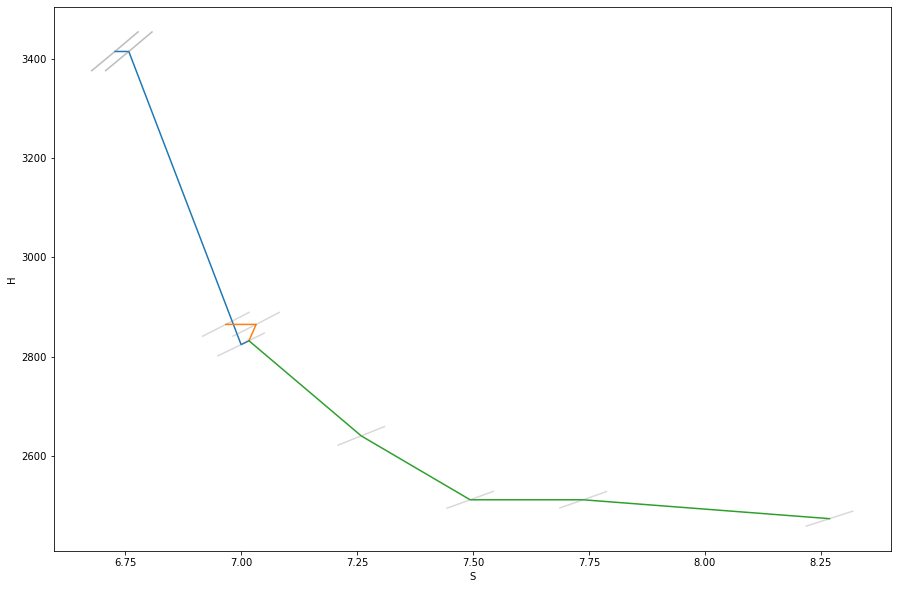

,T,P,H,G,S,X
AIR,7.0,0.1,NaN,NaN,NaN,NaN
PEVD-DROSVD,508.077199,8.368959,3415.161617,63.295824,6.727265,NaN
IVD-PEVD,300.988842,8.708185,2747.714223,63.295824,NaN,NaN
EVD-IVD,298.98032,8.708185,1339.021114,63.295824,NaN,NaN
PEN-EVD,163.464414,8.708185,695.178921,63.295824,NaN,NaN
BND-PEN,162.002703,0.650371,684.180635,63.295824,NaN,NaN
PPND-DROSND,207.616373,0.644434,2865.023717,14.965397,6.966635,NaN
IND-PPND,162.002703,0.650371,2759.623673,14.965397,NaN,NaN
GPK-IND,158.175899,0.650371,667.589372,78.261221,NaN,NaN
GPK-REC,158.175899,0.650371,667.589372,93.349754,NaN,NaN


In [11]:
import matplotlib.pyplot as plt

water_streams.at["PEVD-DROSVD", "S"] = water.p_h(
    water_streams.at["PEVD-DROSVD", "P"], water_streams.at["PEVD-DROSVD", "H"]
)["s"]
water_streams.at["PPND-DROSND", "S"] = water.p_h(
    water_streams.at["PPND-DROSND", "P"], water_streams.at["PPND-DROSND", "H"]
)["s"]

plt.figure(figsize=(15, 10))
Hvd = [
    water_streams.at["PEVD-DROSVD", "H"],
    water_streams.at["DROSVD-TURBVD", "H"],
    water_streams.at["ENDOFVD", "H"],
    water_streams.at["SMESHEND", "H"],
]
Svd = [
    water_streams.at["PEVD-DROSVD", "S"],
    water_streams.at["DROSVD-TURBVD", "S"],
    water_streams.at["ENDOFVD", "S"],
    water_streams.at["SMESHEND", "S"],
]
Hsm = [
    water_streams.at["PPND-DROSND", "H"],
    water_streams.at["DROSND-TURBND", "H"],
    water_streams.at["SMESHEND", "H"],
]
Ssm = [
    water_streams.at["PPND-DROSND", "S"],
    water_streams.at["DROSND-TURBND", "S"],
    water_streams.at["SMESHEND", "S"],
]
Hnd = [
    water_streams.at["SMESHEND", "H"],
    water_streams.at["DOOTB2", "H"],
    water_streams.at["DOOTB1", "H"],
    water_streams.at["INCND", "H"],
    water_streams.at["INKOND", "H"],
]
Snd = [
    water_streams.at["SMESHEND", "S"],
    water_streams.at["DOOTB2", "S"],
    water_streams.at["DOOTB1", "S"],
    water_streams.at["INCND", "S"],
    water_streams.at["INKOND", "S"],
]

# Давления
stream = "PEVD-DROSVD"
H1 = [
    water.p_s(water_streams.at[stream, "P"], water_streams.at[stream, "S"] - 0.05)["h"],
    water_streams.at[stream, "H"],
    water.p_s(water_streams.at[stream, "P"], water_streams.at[stream, "S"] + 0.05)["h"],
]
S1 = [
    water_streams.at[stream, "S"] - 0.05,
    water_streams.at[stream, "S"],
    water_streams.at[stream, "S"] + 0.05,
]
stream = "DROSVD-TURBVD"
H2 = [
    water.p_s(water_streams.at[stream, "P"], water_streams.at[stream, "S"] - 0.05)["h"],
    water_streams.at[stream, "H"],
    water.p_s(water_streams.at[stream, "P"], water_streams.at[stream, "S"] + 0.05)["h"],
]
S2 = [
    water_streams.at[stream, "S"] - 0.05,
    water_streams.at[stream, "S"],
    water_streams.at[stream, "S"] + 0.05,
]
stream = "ENDOFVD"
H3 = [
    water.p_s(water_streams.at[stream, "P"], water_streams.at[stream, "S"] - 0.05)["h"],
    water_streams.at[stream, "H"],
    water.p_s(water_streams.at[stream, "P"], water_streams.at[stream, "S"] + 0.05)["h"],
]
S3 = [
    water_streams.at[stream, "S"] - 0.05,
    water_streams.at[stream, "S"],
    water_streams.at[stream, "S"] + 0.05,
]
stream = "PEVD-DROSVD"
H4 = [
    water.p_s(water_streams.at[stream, "P"], water_streams.at[stream, "S"] - 0.05)["h"],
    water_streams.at[stream, "H"],
    water.p_s(water_streams.at[stream, "P"], water_streams.at[stream, "S"] + 0.05)["h"],
]
S4 = [
    water_streams.at[stream, "S"] - 0.05,
    water_streams.at[stream, "S"],
    water_streams.at[stream, "S"] + 0.05,
]
stream = "DROSVD-TURBVD"
H5 = [
    water.p_s(water_streams.at[stream, "P"], water_streams.at[stream, "S"] - 0.05)["h"],
    water_streams.at[stream, "H"],
    water.p_s(water_streams.at[stream, "P"], water_streams.at[stream, "S"] + 0.05)["h"],
]
S5 = [
    water_streams.at[stream, "S"] - 0.05,
    water_streams.at[stream, "S"],
    water_streams.at[stream, "S"] + 0.05,
]
stream = "PPND-DROSND"
H6 = [
    water.p_s(water_streams.at[stream, "P"], water_streams.at[stream, "S"] - 0.05)["h"],
    water_streams.at[stream, "H"],
    water.p_s(water_streams.at[stream, "P"], water_streams.at[stream, "S"] + 0.05)["h"],
]
S6 = [
    water_streams.at[stream, "S"] - 0.05,
    water_streams.at[stream, "S"],
    water_streams.at[stream, "S"] + 0.05,
]
stream = "DROSND-TURBND"
H7 = [
    water.p_s(water_streams.at[stream, "P"], water_streams.at[stream, "S"] - 0.05)["h"],
    water_streams.at[stream, "H"],
    water.p_s(water_streams.at[stream, "P"], water_streams.at[stream, "S"] + 0.05)["h"],
]
S7 = [
    water_streams.at[stream, "S"] - 0.05,
    water_streams.at[stream, "S"],
    water_streams.at[stream, "S"] + 0.05,
]

stream = "DOOTB2"
H8 = [
    water.p_s(water_streams.at[stream, "P"], water_streams.at[stream, "S"] - 0.05)["h"],
    water_streams.at[stream, "H"],
    water.p_s(water_streams.at[stream, "P"], water_streams.at[stream, "S"] + 0.05)["h"],
]
S8 = [
    water_streams.at[stream, "S"] - 0.05,
    water_streams.at[stream, "S"],
    water_streams.at[stream, "S"] + 0.05,
]
stream = "DOOTB1"
H9 = [
    water.p_s(water_streams.at[stream, "P"], water_streams.at[stream, "S"] - 0.05)["h"],
    water_streams.at[stream, "H"],
    water.p_s(water_streams.at[stream, "P"], water_streams.at[stream, "S"] + 0.05)["h"],
]
S9 = [
    water_streams.at[stream, "S"] - 0.05,
    water_streams.at[stream, "S"],
    water_streams.at[stream, "S"] + 0.05,
]
stream = "INCND"
H10 = [
    water.p_s(water_streams.at[stream, "P"], water_streams.at[stream, "S"] - 0.05)["h"],
    water_streams.at[stream, "H"],
    water.p_s(water_streams.at[stream, "P"], water_streams.at[stream, "S"] + 0.05)["h"],
]
S10 = [
    water_streams.at[stream, "S"] - 0.05,
    water_streams.at[stream, "S"],
    water_streams.at[stream, "S"] + 0.05,
]
stream = "INKOND"
H11 = [
    water.p_s(water_streams.at[stream, "P"], water_streams.at[stream, "S"] - 0.05)["h"],
    water_streams.at[stream, "H"],
    water.p_s(water_streams.at[stream, "P"], water_streams.at[stream, "S"] + 0.05)["h"],
]
S11 = [
    water_streams.at[stream, "S"] - 0.05,
    water_streams.at[stream, "S"],
    water_streams.at[stream, "S"] + 0.05,
]


plt.plot(Svd, Hvd)
plt.plot(Ssm, Hsm)
plt.plot(Snd, Hnd)
plt.plot(S1, H1,S2,H2,S3,H3,
    S4,
    H4,
    S5,
    H5,
    S6,
    H6,
    S7,
    H7,
    S8,
    H8,
    S9,
    H9,
    S10,
    H10,
    S11,
    H11,
    color="gray",
    alpha=0.3,
)
plt.xlabel("S")
plt.ylabel("H")
plt.show()
water_streams